##### https://www.kaggle.com/davids1992/speech-representation-and-data-exploration

# Speech representation and data exploration

Content:

1. Visualization of the recordings - input features

    1.1. Wave and spectrogram

    1.2. MFCC

    1.3. Sprectrogram in 3d

    1.4. Silence removal

    1.5. Resampling - dimensionality reductions

    1.6. Features extraction steps


2. Dataset investigation

    2.1. Number of files

    2.2. Mean spectrograms and fft

    2.3. Deeper into recordings

    2.4. Length of recordings

    2.5. Note on Gaussian Mixtures modeling

    2.6. Frequency components across the words

    2.7. Anomaly detection


3. Where to look for the inspiration

## Libraries for sounds

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa               # conda install -c conda-forge librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py     # conda install -c plotly plotly
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

# Statistical description
from scipy import stats

%matplotlib inline

## Visualization

### 1. Wave and spectrogram

#### (*) 파일명과 경로 등 변경 필요

In [2]:
train_audio_path = './input/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'

# reading a wav file with sample_rate
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

(1) define a function to calculate spectrogram

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    # ------
    # (*) read spectrogram options~
    #-----------
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

(2) Plot wave

Text(0.5,0,'Seconds')

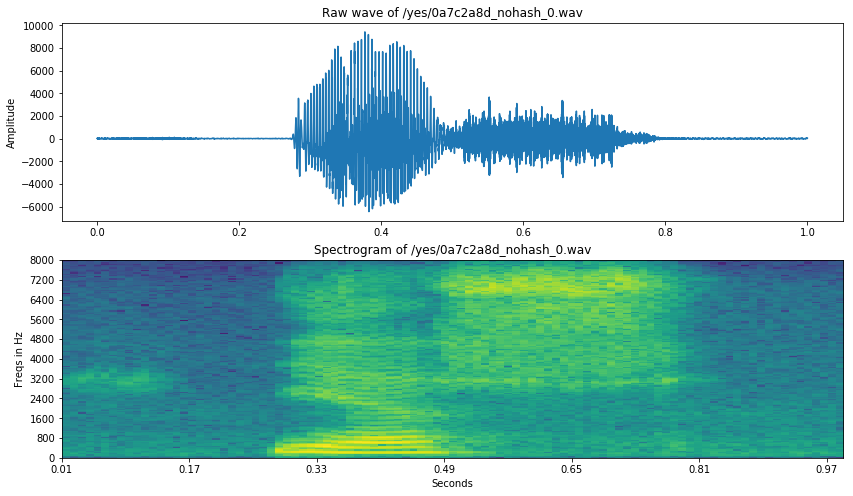

In [4]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)
# 161*99, array

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [5]:
stats.describe(freqs)

DescribeResult(nobs=161, minmax=(0.0, 8000.0), mean=4000.0, variance=5433750.0, skewness=0.0, kurtosis=-1.2000925925925925)

In [6]:
stats.describe(times)

DescribeResult(nobs=99, minmax=(0.01, 0.99), mean=0.5, variance=0.0825, skewness=6.006449136454273e-18, kurtosis=-1.200244897959184)

In [7]:
stats.describe(spectrogram)

DescribeResult(nobs=99, minmax=(array([-13.309396 ,  -8.2931595,  -5.3755665,  -4.804736 ,  -5.965268 ,
        -5.5328455,  -7.260987 ,  -7.2320976, -10.267249 ,  -5.8535147,
        -6.472227 ,  -8.30515  ,  -6.3666096,  -6.5772843,  -5.769606 ,
        -9.379364 ,  -9.845745 ,  -8.693975 ,  -7.5861545,  -6.6032844,
        -7.2958975,  -7.600682 ,  -7.157624 ,  -8.103345 ,  -8.096657 ,
        -9.338631 , -10.310348 ,  -9.145881 ,  -7.8948646,  -7.9696107,
        -8.980438 ,  -9.814818 ,  -7.971973 ,  -7.9399185,  -6.873935 ,
        -8.404921 , -11.18843  ,  -8.219282 , -11.489153 ,  -9.142313 ,
        -8.202052 ,  -8.579775 ,  -9.607233 ,  -9.62118  ,  -7.92284  ,
        -8.824955 ,  -8.126806 , -10.614853 ,  -8.707734 ,  -9.453857 ,
        -9.588938 ,  -9.134114 ,  -9.973239 , -10.251911 ,  -9.73885  ,
        -7.86802  , -11.5633745, -10.437721 , -11.112519 ,  -9.61618  ,
        -9.646619 , -10.691535 , -11.171616 ,  -9.774362 ,  -9.256139 ,
       -11.698669 , -14.115158 ,

(3) Normalize features for NN

In [8]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)

# for z-score normalization
spectrogram = (spectrogram - mean) / std

In [9]:
stats.describe(mean)

DescribeResult(nobs=161, minmax=(-10.258601, 1.6963279), mean=-2.833518, variance=2.7453809, skewness=-0.8494313359260559, kurtosis=4.012543522580387)

### 2. MFCC

##### http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
##### https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

#### Mel Power spectrum and MFCC w/ librosa package

In [10]:
# Errors could be arisen:
# librosa.feature.melspectrogram 
# ParameterError: data must be floating-point
#-----
# load data files for librosa
samples, sample_rate = librosa.load(str(train_audio_path) + filename)

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

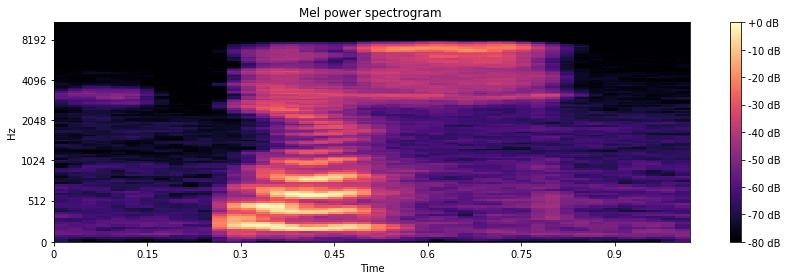

In [11]:
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

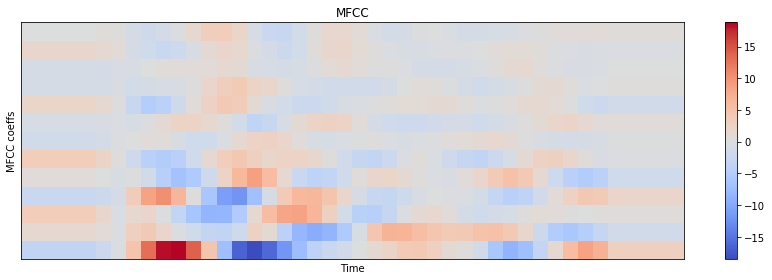

In [12]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

### 3. Spectrogram in 3d _ should be revised for layout problem

In [13]:
# data = [go.Surface(z=spectrogram.T)]
# stats.describe(spectrogram.T)

In [14]:
# layout = go.Layout(
#     title='Specgtrogram of "yes" in 3d',
#     scene = dict(
#     xaxis = dict(
#         title='Time', 
#         range=times,),
#     yaxis = dict(
#         title='Frequencies', 
#         range=freqs,),
#     zaxis = dict(
#         title='Log amplitude',),
#     )
# )

' layout = go.Layout(\n    title=\'Specgtrogram of "yes" in 3d\',\n    scene = dict(\n    xaxis = dict(\n        title=\'Time\', \n        range=times,),\n    yaxis = dict(\n        title=\'Frequencies\', \n        range=freqs,),\n    zaxis = dict(\n        title=\'Log amplitude\',),\n    )\n)'

In [15]:
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig)

NameError: name 'data' is not defined

### 4. Silence Removal

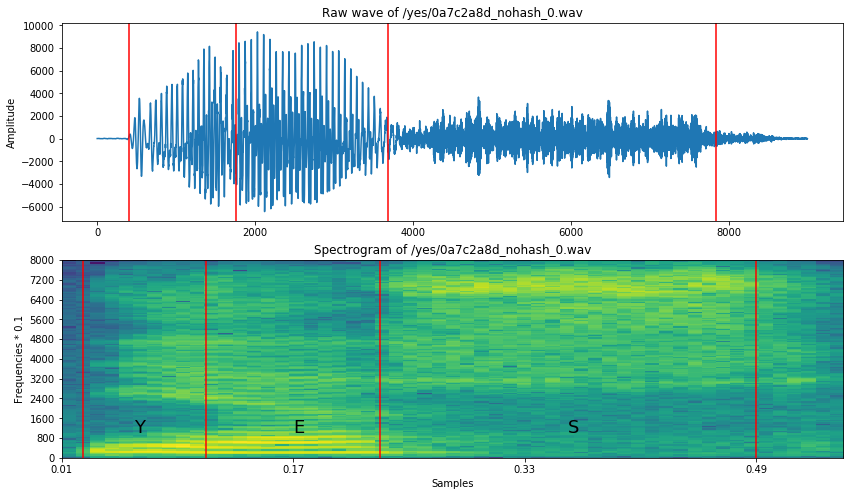

In [18]:
# restore from librosa
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

samples_cut = samples[4000:13000]

freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

### 5. Resampling

#### CUSTOM FFT

In [19]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [21]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

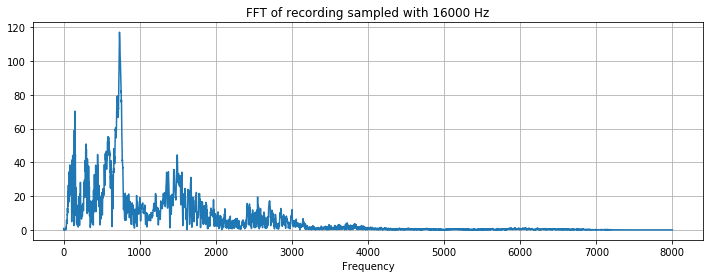

In [22]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

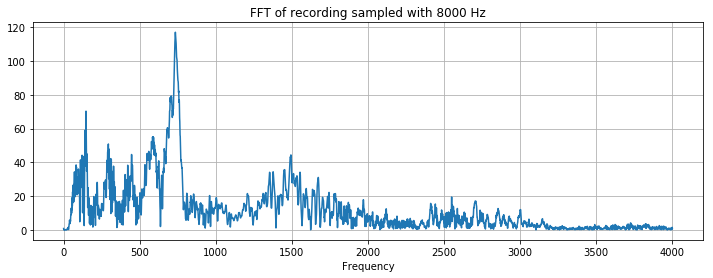

In [23]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

### 6. Features extraction

1. Resampling

2. VAD

3. Maybe padding with 0 to make signals be equal length

4. Log spectrogram (or MFCC, or PLP)

5. Features normalization with mean and std

6. Stacking of a given number of frames to get temporal information

## Dataset investigation

### Number of records

In [26]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 33


In [28]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridis', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

### 2. Deeper into Recordings

There could be noise with different environment..

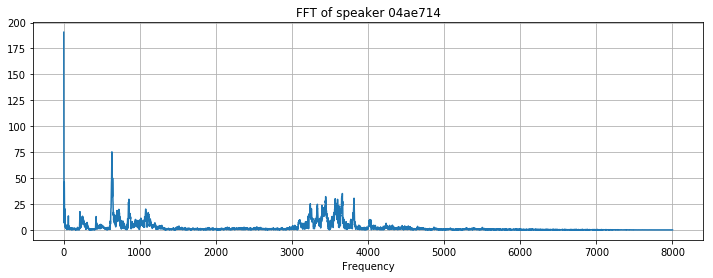

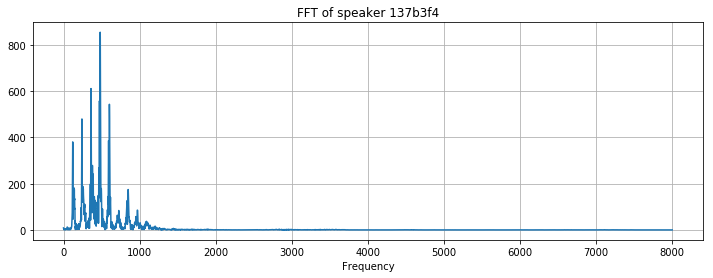

In [30]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

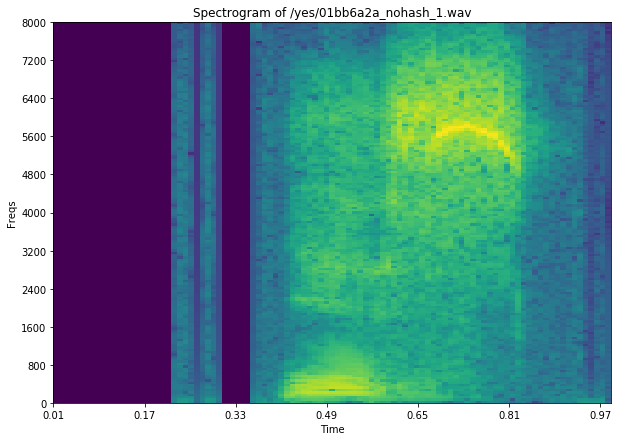

In [31]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

### 3. Recordings length

number of files shorter than 1 second!! = 6469//  We can pad them with zeros.

In [32]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


### Mean spec

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


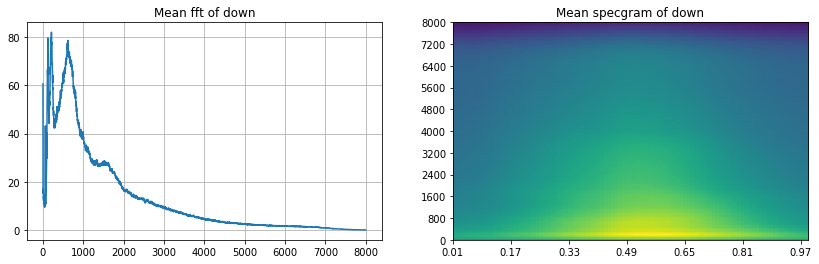

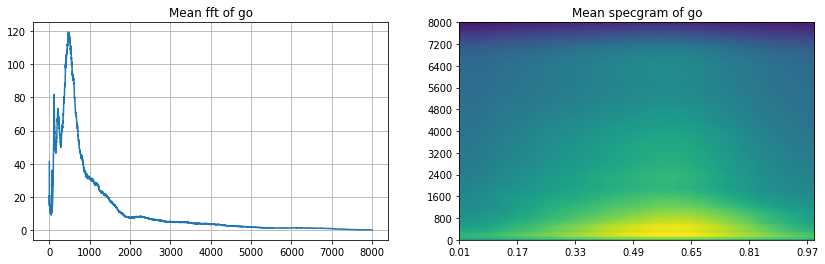

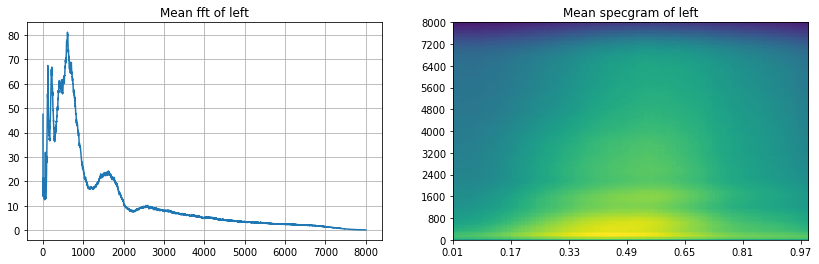

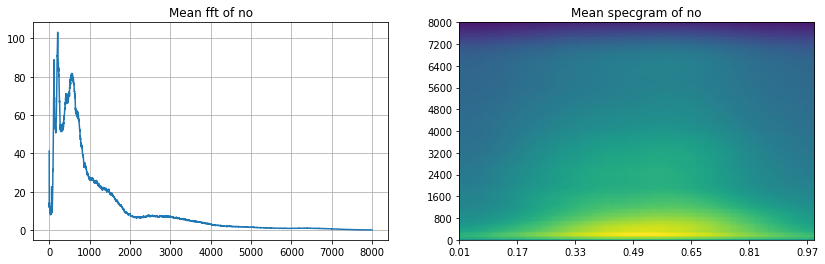

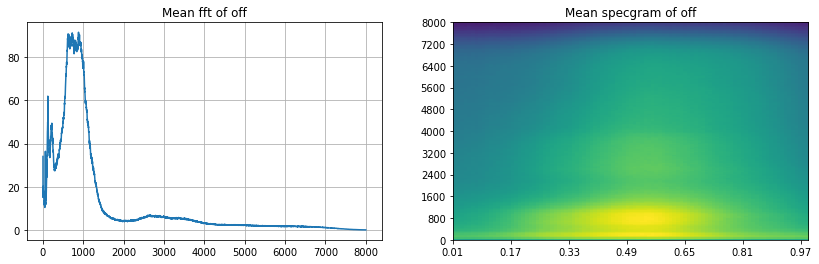

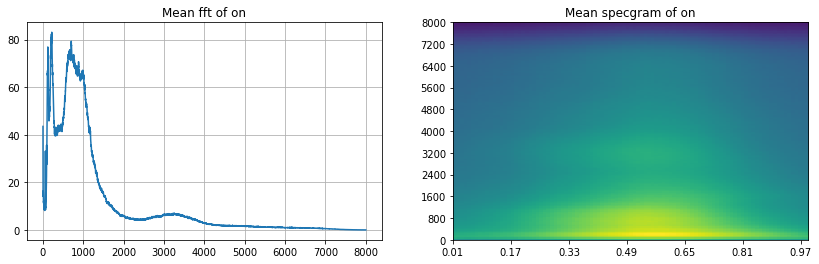

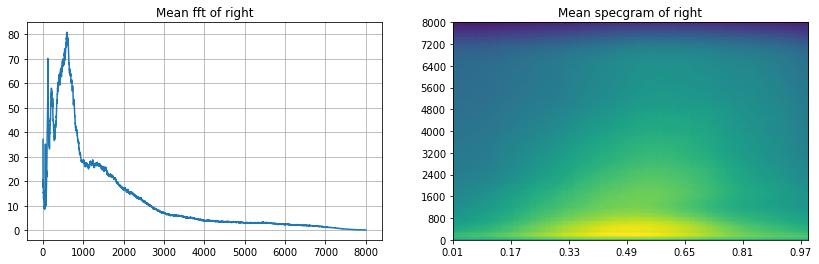

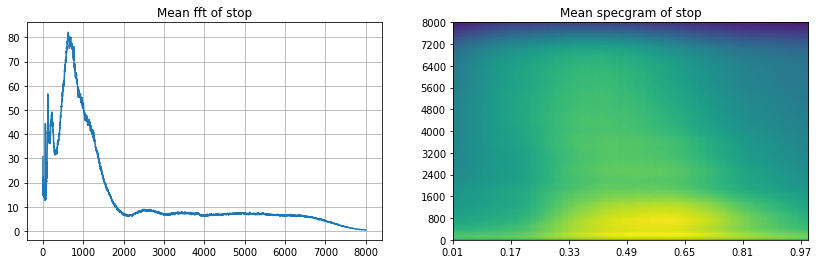

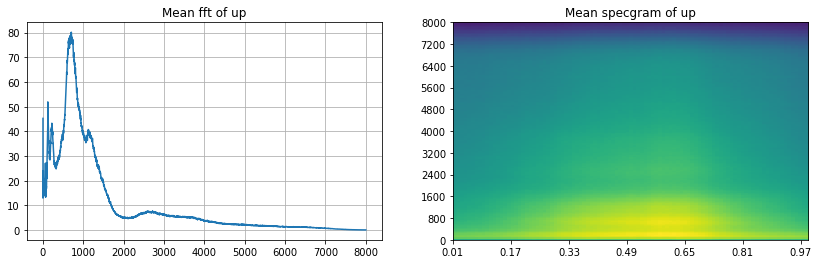

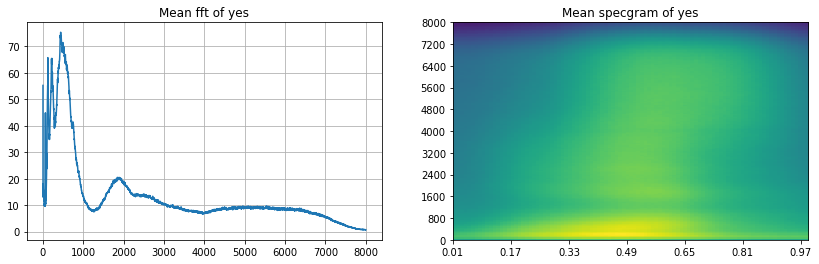

In [33]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

### 5. GMM

###  6. Frequency components across the words


In [34]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

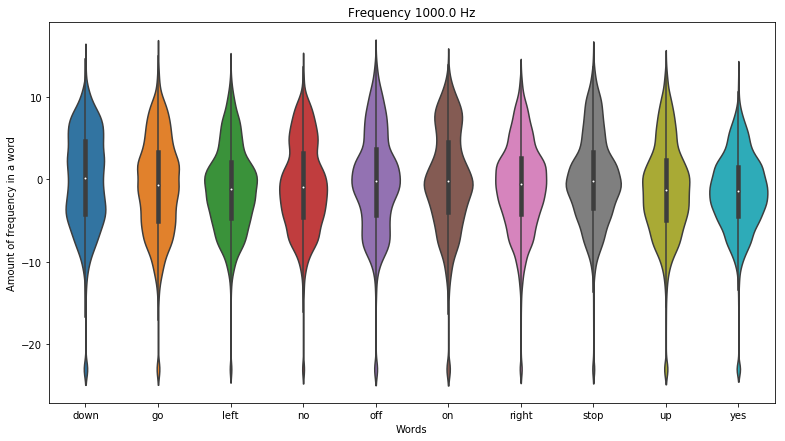

In [35]:
violinplot_frequency(dirs, 20)

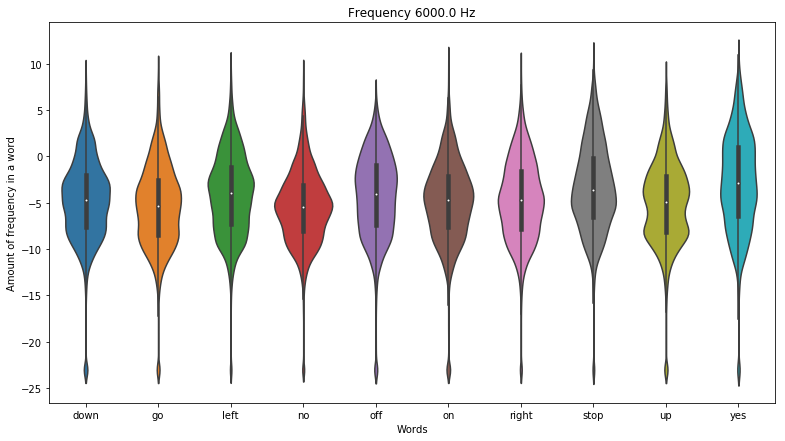

In [36]:
violinplot_frequency(dirs, 120)

### 7. Anomaly ditection

In [ ]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)